<a href="https://colab.research.google.com/github/DevKor-Team/MRDC-Challenge/blob/jo/jo/Transfer_Learning_ResNet50_%2B_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
# 이미지 압축 해제
!unzip -q /content/gdrive/MyDrive/ML/MRDC-competition/data/Images.zip -d /content/gdrive/MyDrive/ML/MRDC-competition/data/images

replace /content/gdrive/MyDrive/ML/MRDC-competition/data/images/id_004wknd7qd.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace /content/gdrive/MyDrive/ML/MRDC-competition/data/images/id_004wknd7qd_rgn.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [2]:
from __future__ import print_function
from __future__ import division

from PIL import Image

import os
import pandas as pd
import numpy as np

import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader
# from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import random_split

import matplotlib.pyplot as plt
import itertools    # confusion matrix에서 사용

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.models as models
import albumentations
import albumentations.pytorch

In [3]:
BASE_DIR = '/content/gdrive/MyDrive/ML/MRDC-competition/data'

import os

train = pd.read_csv(os.path.join(BASE_DIR, 'Train.csv'))
print(train.shape)
train.head()

(5340, 2)


,Image_id,Label
0,id_004wknd7qd.jpg,blast
1,id_004wknd7qd_rgn.jpg,blast
2,id_005sitfgr2.jpg,brown
3,id_005sitfgr2_rgn.jpg,brown
4,id_00stp9t6m6.jpg,blast


In [4]:
train_rgb = train.loc[~train['Image_id'].str.contains('_rgn')]
train_rgb.head()

,Image_id,Label
0,id_004wknd7qd.jpg,blast
2,id_005sitfgr2.jpg,brown
4,id_00stp9t6m6.jpg,blast
6,id_012zxewnhx.jpg,blast
8,id_0186qwq2at.jpg,healthy


In [5]:
test = pd.read_csv(os.path.join(BASE_DIR, 'Test.csv'))
test_rgb = test.loc[~test['Image_id'].str.contains('_rgn')]
test_rgb.head()

,Image_id
0,id_00vl5wvxq3.jpg
2,id_01hu05mtch.jpg
4,id_030ln10ewn.jpg
6,id_03z57m8xht.jpg
8,id_04ngep1w4b.jpg


In [6]:
ss = pd.read_csv(os.path.join(BASE_DIR, 'SampleSubmission.csv'))
ss.head()

,Image_id,blast,brown,healthy
0,id_00vl5wvxq3.jpg,0.0,0.0,0.0
1,id_01hu05mtch.jpg,0.0,0.0,0.0
2,id_030ln10ewn.jpg,0.0,0.0,0.0
3,id_03z57m8xht.jpg,0.0,0.0,0.0
4,id_04ngep1w4b.jpg,0.0,0.0,0.0


In [ ]:
class Img_Dataset(Dataset):
    def __init__(self, file_path, transform, table, is_rgn=False, is_train=True):
        self.file_path = file_path
        self.transform = transform
        self.table = table
        self.is_train = is_train
        
        self.img_name_list = self.table['Image_id'].tolist()
        self.img_list = []
        if not is_rgn:    # RGB
            for img_name in self.img_name_list:
                img = Image.open(os.path.join(self.file_path, img_name))
                img_transformed = self.transform(img)
                self.img_list.append(img_transformed)
        else:
            for img_name in self.img_name_list:
                img_rgn = Image.open(os.path.join(self.file_path, img_name.replace('.jpg', '_rgn.jpg')))
                img_rgn_transformed = self.transform(img_rgn)
                self.img_list.append(img_rgn_transformed)
        
        if self.is_train:
            self.label_list = [0 if label == 'blast' else (1 if label == 'brown' else 2) for label in self.table['Label'].tolist()]
  
    def __len__(self):
        return len(self.img_name_list)
  
    def __getitem__(self, index):
        if self.is_train:
            return self.img_list[index], self.label_list[index]
        else:
            return self.img_list[index]

In [7]:
class EarlyStopping:
    """주어진 patience 이후로 validation loss가 개선되지 않으면 학습을 조기 중지"""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt'):
        """
        Args:
            patience (int): validation loss가 개선된 후 기다리는 기간
                            Default: 7
            verbose (bool): True일 경우 각 validation loss의 개선 사항 메세지 출력
                            Default: False
            delta (float): 개선되었다고 인정되는 monitered quantity의 최소 변화
                            Default: 0
            path (str): checkpoint저장 경로
                            Default: 'checkpoint.pt'
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''validation loss가 감소하면 모델을 저장한다.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [ ]:
def make_data_loader(batch_size=128, split=0.8):
  IMG_DIR = '/content/gdrive/MyDrive/ML/MRDC-competition/data/images'
  transform=transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
  ])

  # train data
  train_dataset = Img_Dataset(IMG_DIR, transform, train_rgb)

  train_size = int(len(train_dataset) * split)
  val_size = len(train_dataset) - train_size

  train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
  val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=2)
  # whole_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)
  
  # test data
  test_dataset = Img_Dataset(IMG_DIR, transform, test_rgb, is_train=False)
  test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
  
  return train_loader, val_loader, test_loader

In [8]:
def train_model(device, model, train_loader, val_loader, criterion, optimizer, num_epochs=5, early_stopping=None):
    model = model.to(device)

    dl = {'train': train_loader,
          'val': val_loader}
    
    val_label = []
    val_pred = []

    val_loss = 0.0
    for epoch in range(num_epochs):
        val_label = []
        val_pred = []

        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dl[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients -> backward시 필요
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)
                    # print(preds)
                    # print(labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    if phase == 'val':    # and epoch == num_epochs - 1:
                        val_label += labels.tolist()
                        val_pred += preds.tolist()
                        # print(val_label)

                # statistics
                running_loss += loss.item() * inputs.size(0)  # size(0) : batch size (첫 번째 차원 개수)
                                                              # item() : tensor에서 저장된 값만 가져오기
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dl[phase].dataset)  # 이렇게 나누면 epoch당 평균 loss가 됨
            epoch_acc = running_corrects.double() / len(dl[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            val_loss = epoch_loss

        if early_stopping != None:
          early_stopping(val_loss, model) # epoch_loss에는 validation loss가 저장
          if early_stopping.early_stop:
            print("Early stopping")
            break

    # load best model weights
    model.load_state_dict(torch.load(early_stopping.path))
    return model, val_label, val_pred

In [9]:
def test_model(device, model, test_loader):
    test_pred = []

    model.eval()
    model = model.to(device)
    with torch.set_grad_enabled(False):
        for features in test_loader:
            features = features.to(device)

            outputs = model(features.to(torch.float))
            probabilities = torch.nn.functional.softmax(outputs[0], dim=0)
            test_pred.append(probabilities.tolist())

    return test_pred

In [10]:
# confusion matrix 시각화
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, target_names=None, labels=True):
    accuracy = np.trace(cm) / float(np.sum(cm))

    cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(9, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    thresh = cm.max() / 2

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names)
        plt.yticks(tick_marks, target_names)

    if labels:
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, "{:,}".format(cm[i, j]), horizontalalignment="center",
                     color="white" if cm[i,j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# ResNet50

In [18]:
class myResNet50(nn.Module):
  def __init__(self, num_classes):
    super(myResNet50, self).__init__()
    self.model_ft = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
    
    num_ftrs = self.model_ft.fc.in_features
    self.model_ft.fc = nn.Linear(num_ftrs, num_classes)

  def forward(self, x):
      # x = self.first_conv(x)
      out = self.model_ft(x)
      return out

'''
def initialize_model(num_classes):
  # Use ResNet50
  model_ft = models.resnet50(weights="IMAGENET1K_V2")
  set_parameter_requires_grad(model_ft)
  # 첫 번째 conv layer 구조 변경
  prev_conv_w = model_ft.conv1.weight  # 기존 모델 weight
  model_ft.conv1 = nn.Conv2d(6, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  model_ft.conv1.weight = nn.Parameter(torch.cat((prev_conv_w, torch.zeros(64, 3, 7, 7)), dim=1))  # 초기 3-dim weight에 3-dim짜리 zero weight를 붙임 
  model_ft.conv1.requires_grad = True
  # 마지막 output layer 구조 변경
  num_ftrs = model_ft.fc.in_features
  model_ft.fc = nn.Linear(num_ftrs, num_classes)

  print("Params to learn:")
  params_to_update = []
  for name,param in model_ft.named_parameters():
    if param.requires_grad == True:
      params_to_update.append(param)
      print("\t",name)

  return model_ft, params_to_update
'''

'\ndef initialize_model(num_classes):\n  # Use ResNet50\n  model_ft = models.resnet50(weights="IMAGENET1K_V2")\n  set_parameter_requires_grad(model_ft)\n  # 첫 번째 conv layer 구조 변경\n  prev_conv_w = model_ft.conv1.weight  # 기존 모델 weight\n  model_ft.conv1 = nn.Conv2d(6, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)\n  model_ft.conv1.weight = nn.Parameter(torch.cat((prev_conv_w, torch.zeros(64, 3, 7, 7)), dim=1))  # 초기 3-dim weight에 3-dim짜리 zero weight를 붙임 \n  model_ft.conv1.requires_grad = True\n  # 마지막 output layer 구조 변경\n  num_ftrs = model_ft.fc.in_features\n  model_ft.fc = nn.Linear(num_ftrs, num_classes)\n\n  print("Params to learn:")\n  params_to_update = []\n  for name,param in model_ft.named_parameters():\n    if param.requires_grad == True:\n      params_to_update.append(param)\n      print("\t",name)\n\n  return model_ft, params_to_update\n'

In [ ]:
resnet50_tf = myResNet50(3)

In [ ]:
# train
train_loader, val_loader, test_loader = make_data_loader(batch_size=128)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer = optim.Adam(resnet50_tf.parameters(), lr=3e-4)
# optimizer = optim.SGD(resnet_ft4.parameters(), lr=3e-4, momentum=0.9)
criterion = nn.CrossEntropyLoss()
MODEL_DIR = '/content/gdrive/MyDrive/ML/MRDC-competition/models'
early_stopping = EarlyStopping(patience=3, verbose=True, delta=0.00001, path=os.path.join(MODEL_DIR, "resnet50-1_checkpoint.pt"))

In [ ]:
resnet50_tf, val_label, val_pred = train_model(device, resnet50_tf, train_loader, val_loader, criterion, optimizer, 30, early_stopping)

Epoch 1/30
----------
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train
train Loss: 0.0032 Acc: 0.9995
val Loss: 0.3390 Acc: 0.8914
EarlyStopping counter: 6 out of 3
Early stopping


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.
  # Remove the CWD from sys.path while we load stuff.


ValueError: ignored

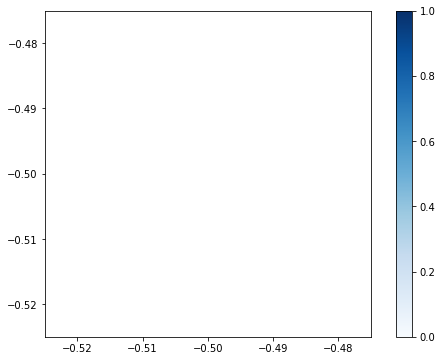

In [ ]:
classes = ['blast', 'brown', 'healthy']
plot_confusion_matrix(confusion_matrix(val_label, val_pred), target_names=classes)

In [ ]:
len(test_loader)

1145

In [ ]:
test_pred = test_model(device, resnet50_tf, test_loader)

In [ ]:
ss.loc[:, ['blast', 'brown', 'healthy']] = test_pred
ss.to_csv("result_resnet50_3.csv", index=False)
ss.head()

,Image_id,blast,brown,healthy
0,id_00vl5wvxq3.jpg,0.999754,0.000062,0.000184
1,id_01hu05mtch.jpg,0.086055,0.909382,0.004563
2,id_030ln10ewn.jpg,0.883682,0.029295,0.087023
3,id_03z57m8xht.jpg,0.999695,0.000122,0.000183
4,id_04ngep1w4b.jpg,0.999287,0.000357,0.000356


score : 0.39

# ResNet50 + Data Augmentation

In [ ]:
train_rgb['Label'].value_counts()

blast      1494
brown       766
healthy     410
Name: Label, dtype: int64

In [ ]:
class Img_Dataset_with_aug(Dataset):
    def __init__(self, file_path, aug_transform, table, is_rgn=False, is_train=True, aug_num=4, test_transform=None):
        self.file_path = file_path
        self.aug_transform = aug_transform
        self.table = table
        self.is_train = is_train
        self.test_transform = test_transform
        
        self.img_name_list = self.table['Image_id'].tolist()
        self.img_list = []
        if self.is_train:   # train -> augmentation 필요
          if not is_rgn:    # RGB
              for img_name in self.img_name_list:
                  img = Image.open(os.path.join(self.file_path, img_name))
                  for _ in range(aug_num):
                    img_transformed = self.aug_transform(image=np.array(img))['image']
                    self.img_list.append(img_transformed)
          else:   # RGN
              for img_name in self.img_name_list:
                  img_rgn = Image.open(os.path.join(self.file_path, img_name.replace('.jpg', '_rgn.jpg')))
                  for _ in range(aug_num):
                    img_rgn_transformed = self.aug_transform(image=np.array(img_rgn))['image']
                    self.img_list.append(img_rgn_transformed)

          self.label_list = []
          for label in self.table['Label'].tolist():
            for _ in range(aug_num):
              self.label_list.append(0 if label == 'blast' else (1 if label == 'brown' else 2))

        else:   # test -> augmentation 필요X
            for img_name in self.img_name_list:
                if not is_rgn:
                  img = Image.open(os.path.join(self.file_path, img_name))
                else:
                  img = Image.open(os.path.join(self.file_path, img_name.replace('.jpg', '_rgn.jpg')))
                img_transformed = self.test_transform(image=np.array(img))['image']
                self.img_list.append(img_transformed)
  
    def __len__(self):
        return len(self.img_list)
  
    def __getitem__(self, index):
        if self.is_train:
            return self.img_list[index], self.label_list[index]
        else:
            return self.img_list[index]

In [ ]:
def make_data_loader_with_aug(batch_size=128, split=0.8, aug_num=4):
  IMG_DIR = '/content/gdrive/MyDrive/ML/MRDC-competition/data/images'
  aug_transform=albumentations.Compose([
    albumentations.Resize(256, 256),
    albumentations.RandomCrop(224, 224),
    albumentations.OneOf([
                          albumentations.HorizontalFlip(p=1),
                          albumentations.RandomRotate90(p=1),
                          albumentations.VerticalFlip(p=1)            
    ], p=1),
    albumentations.OneOf([
                          albumentations.MotionBlur(p=1),
                          albumentations.OpticalDistortion(p=1),
                          albumentations.GaussNoise(p=1)                 
    ], p=0.5),
    albumentations.pytorch.ToTensor(),
  ])
  test_transform=albumentations.Compose([
    albumentations.Resize(224, 224),
    albumentations.pytorch.ToTensor(),
  ])

  # train data
  train_dataset = Img_Dataset_with_aug(IMG_DIR, aug_transform, train_rgb, aug_num=aug_num)

  train_size = int(len(train_dataset) * split)
  val_size = len(train_dataset) - train_size

  train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
  val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=2)
  # whole_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)
  
  # test data
  test_dataset = Img_Dataset_with_aug(IMG_DIR, aug_transform, test_rgb, is_train=False, test_transform=test_transform)
  test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
  
  return train_loader, val_loader, test_loader

In [ ]:
# del resnet50_tf2
resnet50_tf3 = myResNet50(3)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
# train
train_loader, val_loader, test_loader = make_data_loader_with_aug(batch_size=128, aug_num=3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer = optim.Adam(resnet50_tf3.parameters(), lr=1e-4)
# optimizer = optim.SGD(resnet_ft4.parameters(), lr=3e-4, momentum=0.9)
criterion = nn.CrossEntropyLoss()
MODEL_DIR = '/content/gdrive/MyDrive/ML/MRDC-competition/models'
early_stopping = EarlyStopping(patience=3, verbose=True, delta=0.00001, path=os.path.join(MODEL_DIR, "resnet50-aug2_checkpoint.pt"))

In [ ]:
len(train_loader.dataset)

6408

In [ ]:
len(val_loader.dataset)

1602

In [ ]:
resnet50_tf3_res, val_label, val_pred = train_model(device, resnet50_tf3, train_loader, val_loader, criterion, optimizer, 30, early_stopping)

Epoch 1/30
----------
train Loss: 0.7151 Acc: 0.6996
val Loss: 0.4456 Acc: 0.8308
Validation loss decreased (inf --> 0.445621).  Saving model ...
Epoch 2/30
----------
train Loss: 0.2363 Acc: 0.9229
val Loss: 0.2708 Acc: 0.9045
Validation loss decreased (0.445621 --> 0.270773).  Saving model ...
Epoch 3/30
----------
train Loss: 0.0594 Acc: 0.9860
val Loss: 0.1963 Acc: 0.9263
Validation loss decreased (0.270773 --> 0.196272).  Saving model ...
Epoch 4/30
----------
train Loss: 0.0157 Acc: 0.9970
val Loss: 0.2019 Acc: 0.9332
EarlyStopping counter: 1 out of 3
Epoch 5/30
----------
train Loss: 0.0123 Acc: 0.9973
val Loss: 0.2544 Acc: 0.9176
EarlyStopping counter: 2 out of 3
Epoch 6/30
----------
train Loss: 0.0185 Acc: 0.9958
val Loss: 0.2532 Acc: 0.9176
EarlyStopping counter: 3 out of 3
Early stopping


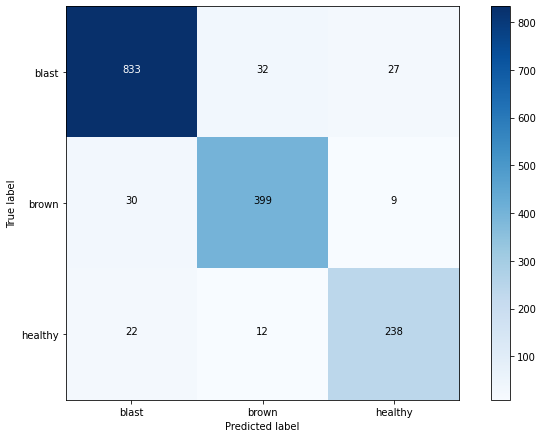

In [ ]:
classes = ['blast', 'brown', 'healthy']
plot_confusion_matrix(confusion_matrix(val_label, val_pred), target_names=classes)

In [ ]:
test_pred = test_model(device, resnet50_tf3_res, test_loader)

In [ ]:
test_pred2 = test_model(device, resnet50_tf3, test_loader)

In [ ]:
ss.loc[:, ['blast', 'brown', 'healthy']] = test_pred2
ss.to_csv("result_resnet50_aug2-1.csv", index=False)
ss.head()

,Image_id,blast,brown,healthy
0,id_00vl5wvxq3.jpg,0.996884,0.000710,0.002406
1,id_01hu05mtch.jpg,0.000202,0.999626,0.000172
2,id_030ln10ewn.jpg,0.125542,0.837417,0.037042
3,id_03z57m8xht.jpg,0.998988,0.000316,0.000695
4,id_04ngep1w4b.jpg,0.983293,0.003929,0.012778


In [ ]:
ss.loc[:, ['blast', 'brown', 'healthy']] = test_pred
ss.to_csv("result_resnet50_aug2.csv", index=False)
ss.head()

,Image_id,blast,brown,healthy
0,id_00vl5wvxq3.jpg,0.996884,0.000710,0.002406
1,id_01hu05mtch.jpg,0.000202,0.999626,0.000172
2,id_030ln10ewn.jpg,0.125542,0.837417,0.037042
3,id_03z57m8xht.jpg,0.998988,0.000316,0.000695
4,id_04ngep1w4b.jpg,0.983293,0.003929,0.012778


score : 0.34

# Augmentaion을 더 많이 해 보장

In [ ]:
def make_data_loader_with_aug2(batch_size=128, split=0.8, aug_num=4, is_rgn=False):
  IMG_DIR = '/content/gdrive/MyDrive/ML/MRDC-competition/data/images'
  aug_transform=albumentations.Compose([
    albumentations.Resize(256, 256),
    albumentations.RandomCrop(224, 224),
    albumentations.OneOf([
                          albumentations.HorizontalFlip(p=1),
                          albumentations.RandomRotate90(p=1),
                          albumentations.VerticalFlip(p=1)            
    ], p=1),
    albumentations.OneOf([
                          albumentations.MotionBlur(p=1),
                          albumentations.OpticalDistortion(p=1),
                          albumentations.GaussNoise(p=1)                 
    ], p=0.5),
    albumentations.pytorch.ToTensor(),
  ])
  test_transform=albumentations.Compose([
    albumentations.Resize(224, 224),
    albumentations.pytorch.ToTensor(),
  ])

  # train data
  train_dataset = Img_Dataset_with_aug(IMG_DIR, aug_transform, train_rgb, is_rgn=is_rgn, aug_num=aug_num)

  train_size = int(len(train_dataset) * split)
  val_size = len(train_dataset) - train_size

  train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
  val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=2)
  # whole_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)
  
  # test data
  test_dataset = Img_Dataset_with_aug(IMG_DIR, aug_transform, test_rgb, is_rgn=is_rgn, is_train=False, test_transform=test_transform)
  test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
  
  return train_loader, val_loader, test_loader

In [ ]:
resnet50_tf4 = myResNet50(3)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
# train
train_loader, val_loader, test_loader = make_data_loader_with_aug(batch_size=128)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer = optim.Adam(resnet50_tf4.parameters(), lr=1e-4)
# optimizer = optim.SGD(resnet_ft4.parameters(), lr=3e-4, momentum=0.9)
criterion = nn.CrossEntropyLoss()
MODEL_DIR = '/content/gdrive/MyDrive/ML/MRDC-competition/models'
early_stopping = EarlyStopping(patience=3, verbose=True, delta=0.00001, path=os.path.join(MODEL_DIR, "resnet50-aug4_checkpoint.pt"))

In [ ]:
print(len(train_loader.dataset))
print(len(val_loader.dataset))

8544
2136


In [ ]:
resnet50_tf4_res, val_label, val_pred = train_model(device, resnet50_tf4, train_loader, val_loader, criterion, optimizer, 30, early_stopping)

Epoch 1/30
----------
train Loss: 0.7244 Acc: 0.6959
val Loss: 0.4726 Acc: 0.8165
Validation loss decreased (inf --> 0.472586).  Saving model ...
Epoch 2/30
----------
train Loss: 0.2676 Acc: 0.9078
val Loss: 0.3394 Acc: 0.8731
Validation loss decreased (0.472586 --> 0.339371).  Saving model ...
Epoch 3/30
----------
train Loss: 0.0664 Acc: 0.9824
val Loss: 0.3255 Acc: 0.8951
Validation loss decreased (0.339371 --> 0.325549).  Saving model ...
Epoch 4/30
----------
train Loss: 0.0165 Acc: 0.9974
val Loss: 0.3312 Acc: 0.8923
EarlyStopping counter: 1 out of 3
Epoch 5/30
----------
train Loss: 0.0058 Acc: 0.9994
val Loss: 0.3614 Acc: 0.8951
EarlyStopping counter: 2 out of 3
Epoch 6/30
----------
train Loss: 0.0051 Acc: 0.9994
val Loss: 0.3661 Acc: 0.8895
EarlyStopping counter: 3 out of 3
Early stopping


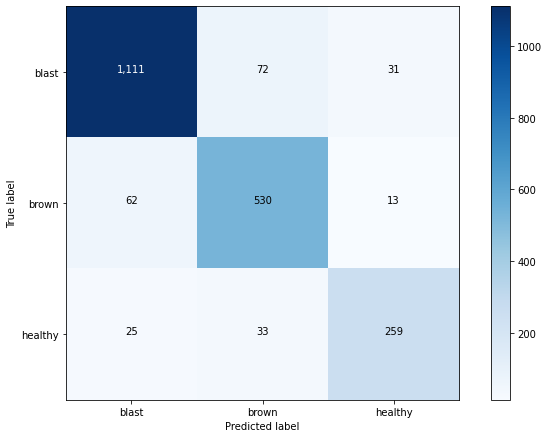

In [ ]:
classes = ['blast', 'brown', 'healthy']
plot_confusion_matrix(confusion_matrix(val_label, val_pred), target_names=classes)

In [ ]:
test_pred = test_model(device, resnet50_tf4, test_loader)

In [ ]:
ss.loc[:, ['blast', 'brown', 'healthy']] = test_pred
ss.to_csv("result_resnet50_aug4.csv", index=False)
ss.head()

,Image_id,blast,brown,healthy
0,id_00vl5wvxq3.jpg,0.997682,0.000683,0.001636
1,id_01hu05mtch.jpg,0.002364,0.995197,0.002439
2,id_030ln10ewn.jpg,0.000717,0.998575,0.000708
3,id_03z57m8xht.jpg,0.992053,0.003692,0.004255
4,id_04ngep1w4b.jpg,0.956157,0.024345,0.019498


score : 0.97.... why?

# Use RGN Image

In [ ]:
resnet50_rgn_tf = myResNet50(3)
train_loader, val_loader, test_loader = make_data_loader_with_aug2(batch_size=128, is_rgn=True)
optimizer = optim.Adam(resnet50_rgn_tf.parameters(), lr=3e-4)
early_stopping = EarlyStopping(patience=3, verbose=True, delta=0.00001, path=os.path.join(MODEL_DIR, "resnet50_rgn_checkpoint.pt"))

In [ ]:
resnet50_rgn_tf, val_label, val_pred = train_model(device, resnet50_rgn_tf, train_loader, val_loader, criterion, optimizer, 30, early_stopping)

Epoch 1/30
----------
train Loss: 1.0735 Acc: 0.4751
val Loss: 1.0779 Acc: 0.4541
Validation loss decreased (inf --> 1.077912).  Saving model ...
Epoch 2/30
----------
train Loss: 1.0728 Acc: 0.4692
val Loss: 1.0773 Acc: 0.4579
Validation loss decreased (1.077912 --> 1.077274).  Saving model ...
Epoch 3/30
----------
train Loss: 1.0729 Acc: 0.4713
val Loss: 1.0775 Acc: 0.4546
EarlyStopping counter: 1 out of 3
Epoch 4/30
----------
train Loss: 1.0724 Acc: 0.4751
val Loss: 1.0776 Acc: 0.4532
EarlyStopping counter: 2 out of 3
Epoch 5/30
----------
train Loss: 1.0722 Acc: 0.4731
val Loss: 1.0768 Acc: 0.4574
Validation loss decreased (1.077274 --> 1.076805).  Saving model ...
Epoch 6/30
----------
train Loss: 1.0726 Acc: 0.4724
val Loss: 1.0779 Acc: 0.4537
EarlyStopping counter: 1 out of 3
Epoch 7/30
----------
train Loss: 1.0723 Acc: 0.4707
val Loss: 1.0765 Acc: 0.4541
Validation loss decreased (1.076805 --> 1.076462).  Saving model ...
Epoch 8/30
----------


KeyboardInterrupt: ignored

-> 학습이 안 되어 중지
-> RGN 이미지는 안 쓰는 것이 답!!!

## 상대적으로 개수가 적은 brown과 healthy image만 뻥튀기.
brown : x2, healthy : x4

In [33]:
class Img_Dataset_with_aug3(Dataset):
    def __init__(self, file_path, aug_transform, table, is_train=True, test_transform=None):
        self.file_path = file_path
        self.aug_transform = aug_transform
        self.table = table
        self.is_train = is_train
        self.test_transform = test_transform
        
        self.img_name_list = self.table['Image_id'].tolist()
        self.img_list = []

        if self.is_train:   # train -> augmentation 필요
          self.table_label_list = self.table['Label'].tolist()
          self.label_list = []
          for i, img_name in enumerate(self.img_name_list):
            img = Image.open(os.path.join(self.file_path, img_name))
            if self.table_label_list[i] == 'blast':
              img_transformed = self.test_transform(image=np.array(img))['image']
              self.img_list.append(img_transformed)
              self.label_list.append(0)
            elif self.table_label_list[i] == 'brown':
              for _ in range(2):   
                img_transformed = self.aug_transform(image=np.array(img))['image']
                self.img_list.append(img_transformed)
                self.label_list.append(1)
            else:
              for _ in range(4):   
                img_transformed = self.aug_transform(image=np.array(img))['image']
                self.img_list.append(img_transformed)
                self.label_list.append(2)

        else:   # test -> augmentation 필요X
            for img_name in self.img_name_list:
                img = Image.open(os.path.join(self.file_path, img_name))
                img_transformed = self.test_transform(image=np.array(img))['image']
                self.img_list.append(img_transformed)
  
    def __len__(self):
        return len(self.img_list)
  
    def __getitem__(self, index):
        if self.is_train:
            return self.img_list[index], self.label_list[index]
        else:
            return self.img_list[index]

In [31]:
def make_data_loader_with_aug3(batch_size=128, split=0.8, aug_num=4):
  IMG_DIR = '/content/gdrive/MyDrive/ML/MRDC-competition/data/images'
  aug_transform=albumentations.Compose([
    albumentations.Resize(256, 256),
    albumentations.RandomCrop(224, 224),
    albumentations.OneOf([
                          albumentations.HorizontalFlip(p=1),
                          albumentations.RandomRotate90(p=1),
                          albumentations.VerticalFlip(p=1)            
    ], p=1),
    albumentations.OneOf([
                          albumentations.MotionBlur(p=1),
                          albumentations.OpticalDistortion(p=1),
                          albumentations.GaussNoise(p=1)                 
    ], p=0.5),
    albumentations.Normalize(),
    albumentations.pytorch.ToTensor(),
  ])
  test_transform=albumentations.Compose([
    albumentations.Resize(224, 224),
    albumentations.pytorch.ToTensor(),
  ])

  # train data
  train_dataset = Img_Dataset_with_aug3(IMG_DIR, aug_transform, train_rgb, test_transform=test_transform)

  train_size = int(len(train_dataset) * split)
  val_size = len(train_dataset) - train_size

  train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
  val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=2)
  
  # test data
  test_dataset = Img_Dataset_with_aug3(IMG_DIR, aug_transform, test_rgb, is_train=False, test_transform=test_transform)
  test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
  
  return train_loader, val_loader, test_loader

In [19]:
resnet50_tf5 = myResNet50(3)  # myResNet50 class의 pretrained model 불러올 때 인자를 조금 바꿨음

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [34]:
# train
train_loader, val_loader, test_loader = make_data_loader_with_aug3(batch_size=128)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer = optim.Adam(resnet50_tf5.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()
MODEL_DIR = '/content/gdrive/MyDrive/ML/MRDC-competition/models'
early_stopping = EarlyStopping(patience=3, verbose=True, delta=0.00001, path=os.path.join(MODEL_DIR, "resnet50-aug5_checkpoint.pt"))

In [36]:
resnet50_tf5, val_label, val_pred = train_model(device, resnet50_tf5, train_loader, val_loader, criterion, optimizer, 30, early_stopping)

Epoch 1/30
----------
train Loss: 0.5878 Acc: 0.7939
val Loss: 0.2049 Acc: 0.9315
Validation loss decreased (inf --> 0.204926).  Saving model ...
Epoch 2/30
----------
train Loss: 0.1159 Acc: 0.9598
val Loss: 0.1038 Acc: 0.9593
Validation loss decreased (0.204926 --> 0.103768).  Saving model ...
Epoch 3/30
----------
train Loss: 0.0211 Acc: 0.9954
val Loss: 0.0733 Acc: 0.9754
Validation loss decreased (0.103768 --> 0.073269).  Saving model ...
Epoch 4/30
----------
train Loss: 0.0078 Acc: 0.9984
val Loss: 0.0584 Acc: 0.9797
Validation loss decreased (0.073269 --> 0.058394).  Saving model ...
Epoch 5/30
----------
train Loss: 0.0163 Acc: 0.9960
val Loss: 0.1576 Acc: 0.9507
EarlyStopping counter: 1 out of 3
Epoch 6/30
----------
train Loss: 0.0153 Acc: 0.9965
val Loss: 0.0610 Acc: 0.9764
EarlyStopping counter: 2 out of 3
Epoch 7/30
----------
train Loss: 0.0153 Acc: 0.9957
val Loss: 0.0693 Acc: 0.9754
EarlyStopping counter: 3 out of 3
Early stopping


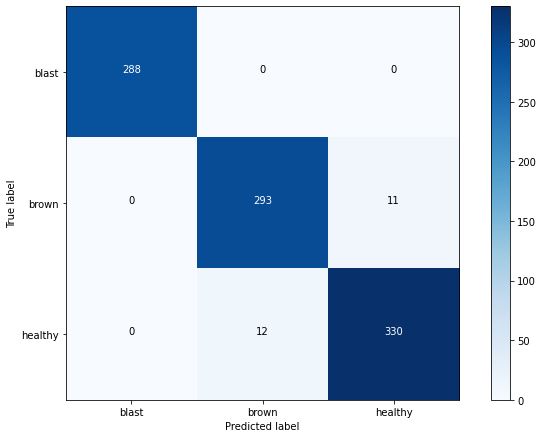

In [37]:
classes = ['blast', 'brown', 'healthy']
plot_confusion_matrix(confusion_matrix(val_label, val_pred), target_names=classes)

In [38]:
test_pred = test_model(device, resnet50_tf5, test_loader)

In [39]:
ss.loc[:, ['blast', 'brown', 'healthy']] = test_pred
ss.to_csv("result_resnet50_aug5.csv", index=False)
ss.head()

,Image_id,blast,brown,healthy
0,id_00vl5wvxq3.jpg,0.998910,0.000474,0.000616
1,id_01hu05mtch.jpg,0.999968,0.000018,0.000014
2,id_030ln10ewn.jpg,0.999900,0.000048,0.000052
3,id_03z57m8xht.jpg,0.999199,0.000325,0.000476
4,id_04ngep1w4b.jpg,0.999964,0.000020,0.000016


score : 3.xx...
blur 이런 효과는 빼고 그냥 flip, crop으로만 augmentation 하는 게 가장 좋을 듯.